In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import ipywidgets as widgets
import math
from random import randint
from scipy.stats import multivariate_normal
from matplotlib import cm


from sklearn.decomposition import PCA
from sklearn.decomposition import FactorAnalysis
from sklearn.manifold import MDS
from sklearn.manifold import Isomap
from sklearn.manifold import LocallyLinearEmbedding
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.cluster import KMeans
from matplotlib.colors import Normalize
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
from numpy import ma
from sklearn.mixture import GaussianMixture

In [2]:
ratings_ = r"2018_ratings.csv"
personality_ = r"2018-personality-data.csv"
ratings = pd.read_csv(ratings_)
personality = pd.read_csv(personality_)

In [3]:
#From https://stackoverflow.com/questions/9740806/pylab-map-labels-to-colors to convert labels to colors in scatter plot
class TextNorm(Normalize):
    '''Map a list of text values to the float range 0-1'''

    def __init__(self, textvals, clip=False):
        self.clip = clip
        # if you want, clean text here, for duplicate, sorting, etc
        ltextvals = set(textvals)
        self.N = len(ltextvals)
        self.textmap = dict(
            [(text, float(i)/(self.N-1)) for i, text in enumerate(ltextvals)])
        self.vmin = 0
        self.vmax = 1

    def __call__(self, x, clip=None):
        #Normally this would have a lot more to do with masking
        ret = ma.asarray([self.textmap.get(xkey, -1) for xkey in x])
        return ret

    def inverse(self, value):
        return ValueError("TextNorm is not invertible")
    

In [4]:
ratings.head()

,useri,movie_id,rating,tstamp
0,8e7cebf9a234c064b75016249f2ac65e,1,5.0,2001-09-10 17:19:56
1,8e7cebf9a234c064b75016249f2ac65e,2,4.0,2001-09-28 11:34:55
2,8e7cebf9a234c064b75016249f2ac65e,3,4.0,2001-09-28 11:42:50
3,8e7cebf9a234c064b75016249f2ac65e,5,5.0,2001-09-28 11:27:30
4,8e7cebf9a234c064b75016249f2ac65e,6,4.0,2002-01-07 18:12:02


In [5]:
personality

,userid,openness,agreeableness,emotional_stability,conscientiousness,extraversion,assigned metric,assigned condition,movie_1,predicted_rating_1,...,movie_9,predicted_rating_9,movie_10,predicted_rating_10,movie_11,predicted_rating_11,movie_12,predicted_rating_12,is_personalized,enjoy_watching
0,8e7cebf9a234c064b75016249f2ac65e,5.0,2.0,3.0,2.5,6.5,serendipity,high,77658,4.410466,...,120138,4.244817,121372,4.396004,127152,4.120456,95311,4.053847,4,4
1,77c7d756a093150d4377720abeaeef76,7.0,4.0,6.0,5.5,4.0,all,default,94959,4.207280,...,56782,4.019599,5618,3.963953,969,4.174188,1232,4.334877,2,3
2,b7e8a92987a530cc368719a0e60e26a3,4.0,3.0,4.5,2.0,2.5,serendipity,medium,110501,4.868064,...,2288,4.823212,3307,4.676756,1172,4.649281,1212,4.744990,2,2
3,92561f21446e017dd6b68b94b23ad5b7,5.5,5.5,4.0,4.5,4.0,popularity,medium,2905,4.526371,...,3030,4.425689,1281,4.479921,940,4.355061,905,4.317927,3,3
4,030001ac2145a938b07e686a35a2d638,5.5,5.5,3.5,4.5,2.5,popularity,medium,2905,4.526371,...,3030,4.425689,1281,4.479921,940,4.355061,905,4.317927,2,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1829,cff910b71f09b3120289ff6b461a9e03,5.5,3.5,2.5,4.0,5.5,popularity,low,108979,4.246346,...,6643,4.409108,115122,3.960470,7700,4.178546,67997,4.085300,3,3
1830,1ab3a4c2921d8da640854819b0f6cfce,4.0,3.5,4.5,4.0,2.5,serendipity,high,93040,4.227140,...,5618,4.149697,903,4.116152,38061,4.155210,1197,4.045751,3,4
1831,a06386edadf3bc614dadb7044708c46c,6.0,3.0,5.5,3.5,6.0,serendipity,low,106173,3.935297,...,26519,3.998642,89707,4.144870,2571,3.860041,108709,3.899857,3,4
1832,bad56d9506832cd79d874a6b66b3d813,5.0,3.5,1.5,3.5,2.5,serendipity,medium,6874,4.241766,...,92259,4.819710,32,4.059369,3730,4.427336,3435,4.844386,4,4


In [6]:
personality.info

<bound method DataFrame.info of                                 userid   openness   agreeableness  \
0     8e7cebf9a234c064b75016249f2ac65e        5.0             2.0   
1     77c7d756a093150d4377720abeaeef76        7.0             4.0   
2     b7e8a92987a530cc368719a0e60e26a3        4.0             3.0   
3     92561f21446e017dd6b68b94b23ad5b7        5.5             5.5   
4     030001ac2145a938b07e686a35a2d638        5.5             5.5   
...                                ...        ...             ...   
1829  cff910b71f09b3120289ff6b461a9e03        5.5             3.5   
1830  1ab3a4c2921d8da640854819b0f6cfce        4.0             3.5   
1831  a06386edadf3bc614dadb7044708c46c        6.0             3.0   
1832  bad56d9506832cd79d874a6b66b3d813        5.0             3.5   
1833  721ea658e148fc0f76ddd6e2b0e02422        6.5             6.5   

       emotional_stability   conscientiousness   extraversion  \
0                      3.0                 2.5            6.5   
1        

In [7]:
big5 =  personality[[' openness',' agreeableness', ' emotional_stability', ' conscientiousness',' extraversion']]


In [8]:
big5

,openness,agreeableness,emotional_stability,conscientiousness,extraversion
0,5.0,2.0,3.0,2.5,6.5
1,7.0,4.0,6.0,5.5,4.0
2,4.0,3.0,4.5,2.0,2.5
3,5.5,5.5,4.0,4.5,4.0
4,5.5,5.5,3.5,4.5,2.5
...,...,...,...,...,...
1829,5.5,3.5,2.5,4.0,5.5
1830,4.0,3.5,4.5,4.0,2.5
1831,6.0,3.0,5.5,3.5,6.0
1832,5.0,3.5,1.5,3.5,2.5


In [27]:
n=2
dim_redux = {"PCA":PCA(n_components=n), #"MDS": MDS(n_components=2), 
             "FA":FactorAnalysis(n_components=n), 
             "ISO":Isomap(n_components=n)
            }

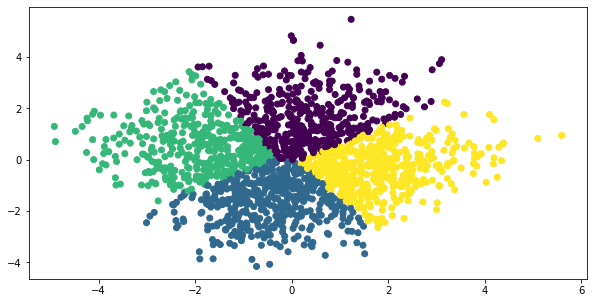

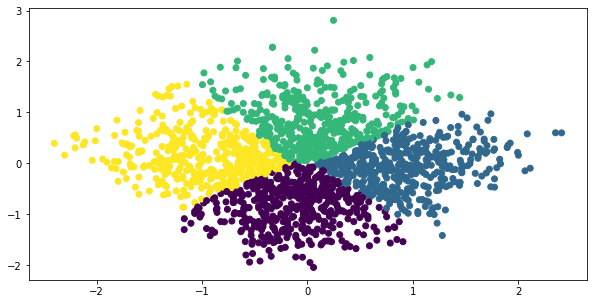

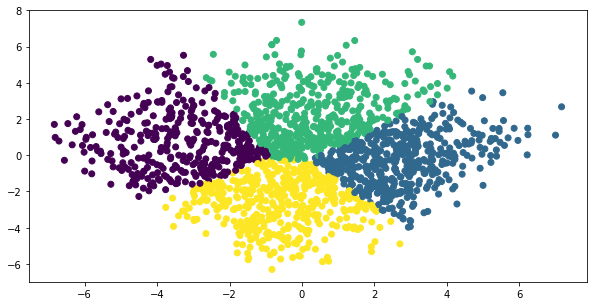

In [32]:
for key, reduction in dim_redux.items():
    reduction.fit(big5)
    #print(reduction.get_covariance())
    reduced_space = reduction.fit_transform(big5)
    y_pred = KMeans(n_clusters=4, random_state=0).fit_predict(reduced_space)
    fig = plt.figure(figsize=(10,5))
    ax = fig.add_subplot(111,)# projection='3d')
    ax.scatter(reduced_space[:,0], reduced_space[:,1], c=y_pred )#, reduced_space[:,2])#, c=y_pred)

In [11]:
mall_customers_ = r'Mall_Customers.csv'
mall_customers = pd.read_csv(mall_customers_) 

In [12]:
mall_customers


,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40
...,...,...,...,...,...
195,196,Female,35,120,79
196,197,Female,45,126,28
197,198,Male,32,126,74
198,199,Male,32,137,18


In [13]:
mall_customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
CustomerID                200 non-null int64
Gender                    200 non-null object
Age                       200 non-null int64
Annual Income (k$)        200 non-null int64
Spending Score (1-100)    200 non-null int64
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


In [14]:
mall_customers.describe()

,CustomerID,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200.000000,200.000000,200.000000
mean,100.500000,38.850000,60.560000,50.200000
std,57.879185,13.969007,26.264721,25.823522
min,1.000000,18.000000,15.000000,1.000000
25%,50.750000,28.750000,41.500000,34.750000
50%,100.500000,36.000000,61.500000,50.000000
75%,150.250000,49.000000,78.000000,73.000000
max,200.000000,70.000000,137.000000,99.000000


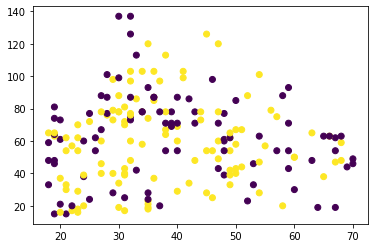

In [15]:
norm = TextNorm(mall_customers['Gender'])
ax, fig = plt.subplots()
plt.scatter(mall_customers['Age'], mall_customers['Annual Income (k$)'], c=norm(mall_customers['Gender']))

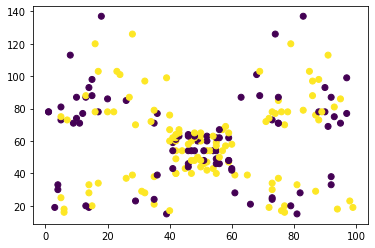

In [16]:
ax, fig = plt.subplots()
plt.scatter(mall_customers['Spending Score (1-100)'], mall_customers['Annual Income (k$)'], c=norm(mall_customers['Gender']))

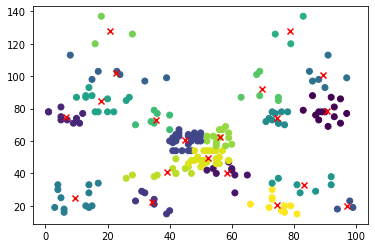

In [17]:
spending_vs_income = mall_customers[['Spending Score (1-100)','Annual Income (k$)']]
kmeans = KMeans(n_clusters=20, random_state=0).fit(spending_vs_income)
y_pred = kmeans.fit_predict(spending_vs_income)
center = kmeans.cluster_centers_

ax, fig = plt.subplots()
plt.scatter(spending_vs_income['Spending Score (1-100)'], spending_vs_income['Annual Income (k$)'], c=y_pred)
plt.scatter(center[:,0], center[:,1], c='red', marker='x')

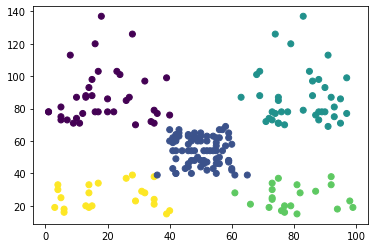

In [18]:
GaussianMixture
gm = GaussianMixture(n_components=5, random_state=0, covariance_type='spherical').fit(spending_vs_income)
y_pred = gm.fit_predict(spending_vs_income)
#center = kmeans.cluster_centers_

ax, fig = plt.subplots()
plt.scatter(spending_vs_income['Spending Score (1-100)'], spending_vs_income['Annual Income (k$)'], c=y_pred)
#lt.scatter(center[:,0], center[:,1], c='red', marker='x')

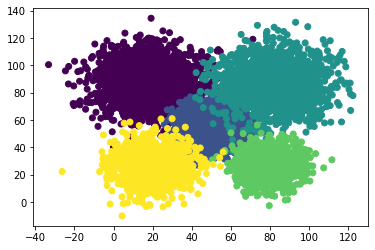

In [19]:
random_sample = gm.sample(10000)
ax, fig = plt.subplots()
plt.scatter(random_sample[0][:,0], random_sample[0][:,1], c=random_sample[1])

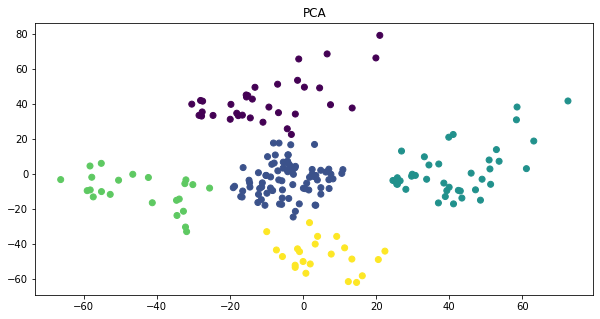

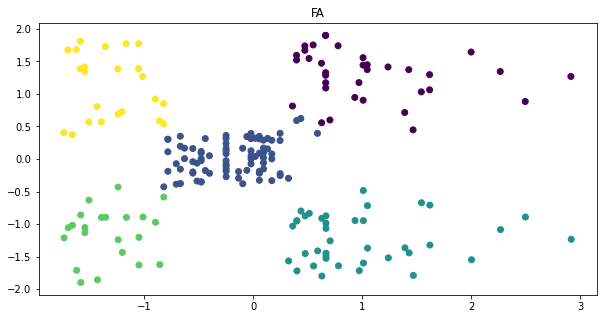

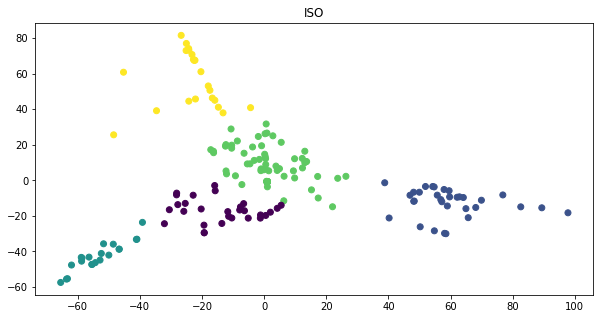

In [40]:
demographics = mall_customers[['Spending Score (1-100)','Annual Income (k$)', 'Age']]
for key, reduction in dim_redux.items():
    reduction.fit(demographics)
    #print(reduction.get_covariance())
    reduced_space = reduction.fit_transform(demographics)
    y_pred = KMeans(n_clusters=5, random_state=0).fit_predict(reduced_space)
    fig = plt.figure(figsize=(10,5))
    ax = fig.add_subplot(111,) #projection='3d')
    ax.scatter(reduced_space[:,0], reduced_space[:,1], c=y_pred)
    ax.set_title(key)